In [1]:
import numpy as np
import pandas as pd

In [13]:
data = pd.read_csv("clean_weather.csv", index_col = 0)
data = data.ffill()

In [14]:
data.head()

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0


### RNN IMPLEMENTATION

In [92]:
from sklearn.preprocessing import StandardScaler
import math

# Define predictors and target
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train, valid, test sets
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

In [93]:
def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

In [94]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
            # Activation.  tanh avoids outputs getting larger and larger.
            hidden_x = np.tanh(hidden_x)
            # Store hidden for use in backprop
            hidden[j,:] = hidden_x

            # Output layer
            output_x = hidden_x @ o_weight + o_bias
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

In [95]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            # Add newaxis in the first dimension
            out_grad = grad[j,:][np.newaxis, :]

            # Output updates
            # np.newaxis creates a size 1 axis, in this case transposing matrix
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad

            # Propagate gradient to hidden unit
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                hh_grad = next_h_grad @ h_weight.T
                # Add the gradients together to combine output contribution and hidden contribution
                h_grad += hh_grad

            # Pull the gradient across the current hidden nonlinearity
            # derivative of tanh is 1 - tanh(x) ** 2
            # So we take the output of tanh (next hidden state), and plug in
            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

            # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
            # Effect is to pull value across nonlinearity
            h_grad = np.multiply(h_grad, tanh_deriv)

            # Store to compute h grad for previous sequence position
            next_h_grad = h_grad.copy()

            # If we're not at the very beginning
            if j > 0:
                # Multiply input from previous layer by post-nonlinearity grad at current layer
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        # Normalize lr by number of sequence elements
        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

In [96]:
epochs = 250
lr = 1e-5

layer_conf = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": 4, "output": 1}
]
layers = init_params(layer_conf)

for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        params = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")

Epoch: 0 train loss 3122.594400144508 valid loss 2171.318686210202
Epoch: 50 train loss 30.593193275313514 valid loss 30.568271740103306
Epoch: 100 train loss 25.263986813543678 valid loss 24.435517510355595
Epoch: 150 train loss 22.95676242953128 valid loss 22.17701097197683
Epoch: 200 train loss 22.306774327704204 valid loss 21.557992202834146


# Step by Step RNN

In [16]:
data.isnull().sum()

tmax             0
tmin             0
rain             0
tmax_tomorrow    0
dtype: int64

In [17]:
data['tmax'].head()

1970-01-01    60.0
1970-01-02    52.0
1970-01-03    52.0
1970-01-04    53.0
1970-01-05    52.0
Name: tmax, dtype: float64

In [25]:
data['tmax'].head(10).to_numpy()[np.newaxis,:]

array([[60., 52., 52., 53., 52., 50., 52., 56., 54., 57.]])

In [26]:
data['tmax']

1970-01-01    60.0
1970-01-02    52.0
1970-01-03    52.0
1970-01-04    53.0
1970-01-05    52.0
              ... 
2022-11-22    62.0
2022-11-23    67.0
2022-11-24    66.0
2022-11-25    70.0
2022-11-26    62.0
Name: tmax, Length: 13509, dtype: float64

In [27]:
np.random.seed(0)

In [28]:
i_weight = np.random.rand(1,2)
h_weight = np.random.rand(2,2)
o_weight = np.random.rand(2,1)

In [30]:
temps = data['tmax'].tail(3).to_numpy()
temps

array([66., 70., 62.])

In [31]:
x0 = temps[0].reshape(1,1)
x1 = temps[1].reshape(1,1)
x2 = temps[2].reshape(1,1)

In [33]:
xi_0 = x0 @ i_weight

xi_0

array([[36.22169126, 47.20249818]])

In [35]:
#Relu fuction
xh_0 = np.maximum(0, xi_0)
xh_0

array([[36.22169126, 47.20249818]])

In [37]:
xo_0 = xh_0 @ o_weight
xo_0

array([[57.94406231]])

In [40]:
xi_1 = x1 @ i_weight
xh = xh_0 @ h_weight

xh_1 = np.maximum(0, xh+xi_1)

xo_1 = xh_1 @ o_weight

xo_1

array([[124.54916092]])

In [41]:
xi_2 = x2 @ i_weight
xh = xh_1 @ h_weight

xh_2 = np.maximum(0, xh+xi_2)

xo_2 = xh_2 @ o_weight

xo_2

array([[190.94853131]])

In [42]:
xh_0

array([[36.22169126, 47.20249818]])

In [43]:
xh_1


array([[ 80.24761908, 100.28766177]])

In [44]:
xh_2

array([[124.88411227, 152.84252918]])

In [46]:
import matplotlib.pyplot as plt


In [47]:
temps = np.arange(-10, 10, .1)
temps

array([-1.00000000e+01, -9.90000000e+00, -9.80000000e+00, -9.70000000e+00,
       -9.60000000e+00, -9.50000000e+00, -9.40000000e+00, -9.30000000e+00,
       -9.20000000e+00, -9.10000000e+00, -9.00000000e+00, -8.90000000e+00,
       -8.80000000e+00, -8.70000000e+00, -8.60000000e+00, -8.50000000e+00,
       -8.40000000e+00, -8.30000000e+00, -8.20000000e+00, -8.10000000e+00,
       -8.00000000e+00, -7.90000000e+00, -7.80000000e+00, -7.70000000e+00,
       -7.60000000e+00, -7.50000000e+00, -7.40000000e+00, -7.30000000e+00,
       -7.20000000e+00, -7.10000000e+00, -7.00000000e+00, -6.90000000e+00,
       -6.80000000e+00, -6.70000000e+00, -6.60000000e+00, -6.50000000e+00,
       -6.40000000e+00, -6.30000000e+00, -6.20000000e+00, -6.10000000e+00,
       -6.00000000e+00, -5.90000000e+00, -5.80000000e+00, -5.70000000e+00,
       -5.60000000e+00, -5.50000000e+00, -5.40000000e+00, -5.30000000e+00,
       -5.20000000e+00, -5.10000000e+00, -5.00000000e+00, -4.90000000e+00,
       -4.80000000e+00, -

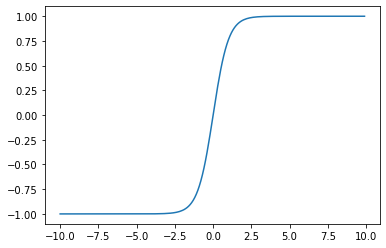

In [48]:
plt.plot(temps, np.tanh(temps))

In [50]:
from sympy import diff, symbols, exp

In [51]:
x = symbols('x')
sympy_tanh = ((exp(x)- exp(-x))/ (exp(x)+ exp(-x)))
diff(sympy_tanh, x)

(-exp(x) + exp(-x))*(exp(x) - exp(-x))/(exp(x) + exp(-x))**2 + 1

In [52]:
x = symbols('x')
sympy_tanh = (pow(x,3))
diff(sympy_tanh, x)

3*x**2

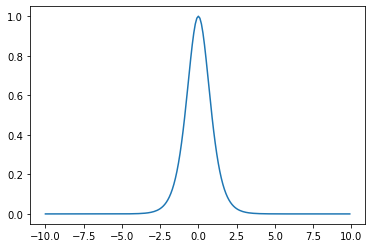

In [53]:
plt.plot(temps, 1-np.tanh(temps)**2)

In [67]:
np.random.seed(0)


i_weight = np.random.rand(1,5) / 5 - .1
h_weight = np.random.rand(5,5) / 5 - .1
h_bias = np.random.rand(1,5) / 5 - .1

o_weight = np.random.rand(5,1) * 50
o_bias = np.random.rand(1,1)

In [68]:
outputs = np.zeros(3)

hiddens = np.zeros((3, 5))


prev_hidden = None
sequence = data["tmax"].tail(3).to_numpy()

for i in range(3):
    
    x = sequence[i].reshape(1,1)

    
    xi = x @ i_weight
    if prev_hidden is not None:
        
        xh = xi + prev_hidden @ h_weight + h_bias
    else:
        xh = xi


    xh = np.tanh(xh)
    prev_hidden = xh
    hiddens[i,] = xh

    # Multiply by the output weight
    xo = xh @ o_weight + o_bias
    outputs[i] = xo

In [69]:
output

array([66., 70., 62.])

In [70]:
hiddens

array([[ 0.56784618,  0.99320288,  0.87557333,  0.53166114, -0.76483255],
       [ 0.58366756,  0.99568651,  0.90034879,  0.69338529, -0.84149203],
       [ 0.5383306 ,  0.99164251,  0.86287584,  0.66091071, -0.80543591]])

In [82]:

def mse(actual, predicted):
    return np.mean((actual-predicted)**2)

def mse_grad(actual, predicted):
    return (predicted - actual)

In [83]:
actuals = np.array([70,62,65])

loss_grad = mse_grad(actuals, output)
loss_grad

array([-4.,  8., -3.])

In [84]:
o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5

In [85]:
l2_grad = loss_grad[2].reshape(1,1)


o_weight_grad += hiddens[2][:,np.newaxis] @ l2_grad

o_bias_grad += np.mean(l2_grad)


h2_grad = l2_grad @ o_weight.T


tanh_deriv = 1 - hiddens[2,:][np.newaxis,:] ** 2

h2_grad = np.multiply(h2_grad, tanh_deriv)


h_weight_grad += hiddens[1,:][:,np.newaxis] @ h2_grad
h_bias_grad += np.mean(h2_grad)


i_weight_grad += sequence[2].reshape(1,1).T @ h2_grad

In [86]:
l1_grad = loss_grad[1].reshape(1,1)

o_weight_grad += hiddens[1][:,np.newaxis] @ l1_grad
o_bias_grad += np.mean(l1_grad)

h1_grad = l1_grad @ o_weight.T


h1_grad += h2_grad @ h_weight.T

# The rest of the operation is the same
tanh_deriv = 1 - hiddens[1,:][np.newaxis,:] ** 2
h1_grad = np.multiply(h1_grad, tanh_deriv)

h_weight_grad += hiddens[1,:][:,np.newaxis] @ h1_grad
h_bias_grad += np.mean(h1_grad)

i_weight_grad += sequence[1].reshape(1,1).T @ h1_grad

In [87]:

l0_grad = loss_grad[0].reshape(1,1)

o_weight_grad += hiddens[0][:,np.newaxis] @ l0_grad
o_bias_grad += np.mean(l0_grad)

h0_grad = l0_grad @ o_weight.T

h0_grad += h1_grad @ h_weight.T

tanh_deriv = 1 - hiddens[0,:][np.newaxis,:] ** 2
h0_grad = np.multiply(h0_grad, tanh_deriv)



i_weight_grad += sequence[0].reshape(1,1).T @ h0_grad

In [88]:
i_weight_grad

array([[2401.10727625,  -44.13925576,  -36.1616835 ,  474.38699519,
        -248.63876973]])

In [89]:

next_hidden = None

o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5

for i in range(2, -1, -1):
    l_grad = loss_grad[i].reshape(1,1)

    o_weight_grad += hiddens[i][:,np.newaxis] @ l_grad
    o_bias_grad += np.mean(l_grad)

    o_grad = l_grad @ o_weight.T

    # Only add in the hidden gradient if a next sequence exists
    if next_hidden is not None:
        h_grad = o_grad + next_hidden @ h_weight.T
    else:
        h_grad = o_grad

    tanh_deriv = 1 - hiddens[i,:][np.newaxis,:] ** 2
    h_grad = np.multiply(h_grad, tanh_deriv)

    next_hidden = h_grad

    # Don't update the hidden weights for the first sequence position
    if i > 0:
        h_weight_grad += hiddens[i-1,:][:,np.newaxis] @ h_grad
        h_bias_grad += np.mean(h_grad)

    i_weight_grad += sequence[i].reshape(1,1).T @ h_grad

In [90]:

lr = 1e-6
# We'll divide the learning rate by the sequence length, since we were adding together the gradients
# This makes training the model more stable
lr = lr / 3

i_weight -= i_weight_grad * lr
h_weight -= h_weight_grad * lr
h_bias -= h_bias_grad * lr
o_weight -= o_weight_grad * lr
o_bias -= o_bias_grad * lr